#Cost of Equity with Alpha and Beta

Get valuable insights into stock performance, risk, and cost of equity with this code. It retrieves historical stock data, calculates risk-free rate and market return, computes market and stock premiums, and estimates cost of equity using CAPM. With rolling regressions, it visualizes trends in stock and market, along with cost of equity, beta, and alpha, helping investors make informed decisions.

# Background

Imports necessary libraries for data manipulation, visualization, and fetching stock data from Yahoo Finance

In [1]:
#!pip install yfinance

In [101]:
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import datetime
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')

# Type in Date and Trade Name

1. Sets up the time frame for historical data, converts the dates to datetime objects, sets the beta duration in years, converts it to months.bold text
2. Sets the trade name, downloads monthly stock data using the yfinance library, adds an index column to the DataFrame, and prints the start and end dates of the stock data.


In [102]:
#History Data Time Frame
Startdate = "2004-06-01"
Enddate = "2024-06-05"

Startdate = pd.to_datetime(Startdate)
Enddate = pd.to_datetime(Enddate)

Beta_year = 5
B = Beta_year*12
B = int(B)
print(B)

Trade_Name = "AAPL"

Stock = yf.download(Trade_Name, interval='1mo')
Stock = Stock.reset_index(drop=False)

60


[*********************100%%**********************]  1 of 1 completed


In [103]:
print(Stock.Date[0].strftime("%Y-%m"))
print(Stock.Date.iloc[-1].strftime("%Y-%m"))

1985-01
2024-06


In [104]:
#Check if the chosen start date is later than the earliest available date in the stock data and interrupt execution if not
try:
    assert Stock.Date[0] < Startdate
except AssertionError:
    raise ValueError(f"Choose start date later than {Stock.Date[0].strftime('%Y-%m')}")

In [105]:
#Calculate the difference in months between the chosen start date and the earliest available date in the stock data.
#It then checks if the total months are greater than Beta duration, raising an error if not.
from dateutil.relativedelta import relativedelta
# Calculate the difference in months
difference = relativedelta(Startdate, Stock.Date.iloc[0])
total_months = difference.years * 12 + difference.months

try:
    assert total_months > B
except AssertionError:
    raise ValueError(f"Change Beta to be less than {round(total_months/12, 5)} or change start date")

# Basic Data

Adjust the start date to go back by the number of years specified by Beta_year, then convert both start and end dates to datetime objects.

In [106]:
Startdate = pd.to_datetime(Startdate) - relativedelta(years=Beta_year)
Enddate = pd.to_datetime(Enddate)

## Risk-free Rate

Downloads data for various Treasury bonds from Yahoo Finance and assigns the chosen Treasury bond/T-Bill data to Risk_Free. Then resets the index and displays summary statistics for the data.

In [107]:
#Risk-Free rate taken as Treasury bond from Yahoo Finance: 13 Week Treasury Bill: ^IRX, 	Treasury Yield 5 Years: ^FVX, Treasury Yield 10 Years: ^TNX, Treasury Yield 30 Years: ^TYX
TB13W = yf.download("^IRX",start=Startdate,end=Enddate, interval='1mo')
TB5 = yf.download("^FVX",start=Startdate,end=Enddate, interval='1mo')
TB10 = yf.download("^TNX",start=Startdate,end=Enddate, interval='1mo')
TB30 = yf.download("^TYX",start=Startdate,end=Enddate, interval='1mo')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [108]:
Risk_Free = TB5
Risk_Free = Risk_Free.reset_index(drop=False)
Risk_Free.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
297,2024-03-01,4.257,4.368,3.994,4.220,4.220,0
298,2024-04-01,4.232,4.753,4.232,4.723,4.723,0
299,2024-05-01,4.698,4.723,4.563,4.567,4.567,0


In [109]:
Risk_Free.iloc[:, 1:].describe()

,Open,High,Low,Close,Adj Close,Volume
count,300.000000,300.000000,300.000000,300.000000,300.000000,3.000000e+02
mean,2.757120,2.960600,2.556883,2.748113,2.748113,2.259200e+04
std,1.560167,1.579677,1.531704,1.556435,1.556435,2.033525e+05
min,0.219000,0.304000,0.192000,0.215000,0.215000,0.000000e+00
25%,1.506500,1.720750,1.324000,1.511000,1.511000,0.000000e+00
50%,2.543000,2.758500,2.347000,2.517000,2.517000,0.000000e+00
75%,4.000500,4.291250,3.775750,4.044500,4.044500,0.000000e+00
max,6.653000,6.830000,6.517000,6.692000,6.692000,2.801100e+06


## Market Index

Download data for various market indices from Yahoo Finance, assigning the chosen index as the market return. Then resets the index, displays the last few rows of the data, and shows summary statistics.

In [110]:
SP_500 = yf.download("^GSPC",start=Startdate,end=Enddate, interval='1mo')
#SP_500 = yf.download("SPY",start=Startdate,end=Enddate, interval='1mo')
NASDAQ = yf.download("^IXIC",start=Startdate,end=Enddate, interval='1mo')
VTI = yf.download("VTI",start=Startdate,end=Enddate, interval='1mo')
Dow_Jones = yf.download("^DJI",start=Startdate,end=Enddate, interval='1mo')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [111]:
#Market Return based on S&P500 Index data from Yahoo Finance
Market = SP_500
Market = Market.reset_index(drop=False)
Market.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
298,2024-04-01,5257.970215,5263.950195,4953.560059,5035.689941,5035.689941,81747170000
299,2024-05-01,5029.029785,5341.879883,5011.049805,5277.509766,5277.509766,86849720000
300,2024-06-01,5297.149902,5375.080078,5234.319824,5360.790039,5360.790039,22271310000


In [112]:
Market.iloc[:, 1:].describe()

,Open,High,Low,Close,Adj Close,Volume
count,301.000000,301.000000,301.000000,301.000000,301.000000,3.010000e+02
mean,2014.022885,2082.264520,1943.375911,2026.053983,2026.053983,6.859960e+10
std,1125.098651,1165.400865,1091.004295,1138.712014,1138.712014,2.998522e+10
min,729.570007,832.979980,666.789978,735.090027,735.090027,1.533293e+10
25%,1207.010010,1239.780029,1165.540039,1207.010010,1207.010010,4.222872e+10
50%,1452.430054,1503.890015,1403.969971,1454.599976,1454.599976,7.348298e+10
75%,2642.959961,2742.239990,2532.689941,2648.050049,2648.050049,8.612273e+10
max,5297.149902,5375.080078,5234.319824,5360.790039,5360.790039,1.621854e+11


## The Chosen Stock

Downloads the stock data for the chosen stock from Yahoo Finance, resets the index, displays the first few rows of the data, and shows summary statistics.

In [113]:
Stock = yf.download(Trade_Name,start = Startdate, end = Enddate, interval='1mo')
Stock = Stock.reset_index(drop=False)
Stock.head(3)

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-06-01,0.401786,0.43750,0.375558,0.413504,0.349598,6918620800
1,1999-07-01,0.413504,0.50558,0.403460,0.497210,0.420368,11466582400
2,1999-08-01,0.496652,0.58817,0.465402,0.582589,0.492551,9244603200


In [114]:
Stock.iloc[:,1:].describe()

,Open,High,Low,Close,Adj Close,Volume
count,301.000000,301.000000,301.000000,301.000000,301.000000,3.010000e+02
mean,37.688753,40.263490,35.495278,38.246755,36.871620,8.300578e+09
std,54.134684,57.555718,51.079955,54.795293,54.514322,6.733789e+09
min,0.253571,0.266964,0.227143,0.252500,0.213477,3.430046e+08
25%,1.678571,1.948571,1.646071,1.914643,1.618740,2.747657e+09
50%,14.206429,15.239286,13.488571,14.456429,12.228868,6.435061e+09
75%,41.792500,44.735001,41.174999,42.259998,39.832817,1.184992e+10
max,196.240005,199.619995,192.149994,196.449997,195.412216,4.142671e+10


# Return Rate

Renames columns, converts date columns to datetime format, calculates the risk-free return per month, and drops NaN values, then displays the last 10 rows of the DataFrame.



Defines a function Return_Rate to calculate return rates for stocks and the market. It renames columns, converts date columns to datetime format, calculates returns, and drops NaN values. Then applies function to the Stock and Market dataframes, displaying the last 10 rows of each dataframe.



In [115]:
#Calcuate risk free return for each month
Risk_Free = Risk_Free.rename(columns = {"Adj Close":"TB"})
Risk_Free["Date"] = pd.to_datetime(Risk_Free["Date"])
Risk_Free["TB"] = pd.to_numeric(Risk_Free["TB"])
#Risk_Free["Risk-Free Return"] = Risk_Free["TB"]/100
#Risk_Free["Risk-Free Return"] = ((1+Risk_Free["Risk-Free Return"])**(1/12))-1

#Risk_Free["Risk-Free Return"] = Risk_Free["TB"].apply(lambda x: ((1 + x / 100) ** (1/12)) - 1)
Risk_Free["Risk-Free Return"] = Risk_Free["TB"].apply(lambda x: (x/12)/100)


Risk_Free = Risk_Free.dropna()

"""
first_value = Risk_Free["Risk-Free Return"].iloc[0]
Risk_Free["Risk-Free Return"] = first_value
"""

Risk_Free = Risk_Free[["Date", "TB", "Risk-Free Return"]]

Risk_Free.tail(10)

,Date,TB,Risk-Free Return
290,2023-08-01,4.244,0.003537
291,2023-09-01,4.606,0.003838
292,2023-10-01,4.816,0.004013
293,2023-11-01,4.298,0.003582
294,2023-12-01,3.840,0.003200
295,2024-01-01,3.882,0.003235
296,2024-02-01,4.262,0.003552
297,2024-03-01,4.220,0.003517
298,2024-04-01,4.723,0.003936
299,2024-05-01,4.567,0.003806


In [116]:
def Return_Rate(x, y, z):
    x = x.rename(columns={"Adj Close": y})
    x["Date"] = pd.to_datetime(x["Date"])
    x[y] = pd.to_numeric(x[y])
    x[y + "_Prev"] = x[y].shift(periods=1)
    x[z] = x[y].pct_change()
    x = x.dropna()

    return x

In [117]:
Stock = Return_Rate(Stock, "Stock Value", "Stock Return")

Market = Return_Rate(Market, "Market Value", "Market Return")

In [118]:
Stock.tail(10)

,Date,Open,High,Low,Close,Stock Value,Volume,Stock Value_Prev,Stock Return
291,2023-09-01,189.490005,189.979996,167.619995,171.210007,170.535522,1337586600,186.877533,-0.087448
292,2023-10-01,171.220001,182.339996,165.669998,170.770004,170.097260,1172719600,170.535522,-0.002570
293,2023-11-01,171.000000,192.929993,170.119995,189.949997,189.201691,1099586100,170.097260,0.112315
294,2023-12-01,190.330002,199.619995,187.449997,192.529999,192.024185,1062774800,189.201691,0.014918
295,2024-01-01,187.149994,196.380005,180.169998,184.399994,183.915543,1187219300,192.024185,-0.042227
296,2024-02-01,183.990005,191.050003,179.250000,180.750000,180.275131,1161627000,183.915543,-0.019794
297,2024-03-01,179.550003,180.529999,168.490005,171.479996,171.247726,1432782800,180.275131,-0.050076
298,2024-04-01,171.190002,178.360001,164.080002,170.330002,170.099289,1245717000,171.247726,-0.006706
299,2024-05-01,169.580002,193.000000,169.110001,192.250000,191.989594,1336537700,170.099289,0.128691
300,2024-06-01,192.899994,197.300003,192.149994,193.119995,193.119995,343004600,191.989594,0.005888


In [119]:
Market.tail(10)

,Date,Open,High,Low,Close,Market Value,Volume,Market Value_Prev,Market Return
291,2023-09-01,4530.600098,4541.250000,4238.629883,4288.049805,4288.049805,73482980000,4507.660156,-0.048719
292,2023-10-01,4284.520020,4393.569824,4103.779785,4193.799805,4193.799805,83519460000,4288.049805,-0.021980
293,2023-11-01,4201.270020,4587.640137,4197.740234,4567.799805,4567.799805,80970570000,4193.799805,0.089179
294,2023-12-01,4559.430176,4793.299805,4546.500000,4769.830078,4769.830078,81530670000,4567.799805,0.044229
295,2024-01-01,4745.200195,4931.089844,4682.109863,4845.649902,4845.649902,81737880000,4769.830078,0.015896
296,2024-02-01,4861.109863,5111.060059,4853.520020,5096.270020,5096.270020,82066930000,4845.649902,0.051721
297,2024-03-01,5098.509766,5264.850098,5056.819824,5254.350098,5254.350098,86299510000,5096.270020,0.031019
298,2024-04-01,5257.970215,5263.950195,4953.560059,5035.689941,5035.689941,81747170000,5254.350098,-0.041615
299,2024-05-01,5029.029785,5341.879883,5011.049805,5277.509766,5277.509766,86849720000,5035.689941,0.048021
300,2024-06-01,5297.149902,5375.080078,5234.319824,5360.790039,5360.790039,22271310000,5277.509766,0.015780


In [120]:
#Calculates the annualized average return of the market over the last 60 months.
Market['Market Return'].tail(60).mean()*12

0.1366841494333481

# Premium

Defines a function Premium to calculate the premium for market and stock. It merges the market or stock data with the risk-free rate data on the 'Date' column, then calculates the premium by subtracting the risk-free return from the market or stock return. Then select necessary columns and rename them accordingly.

In [121]:
def Premium(x, y, z, a, b):
  x = pd.merge(y, Risk_Free, on = "Date")
  x[z] = x[a] - x["Risk-Free Return"]
  x = x[["Date", "Risk-Free Return", z, b]]
  x = x.rename(columns = {"Date_y":"Date"})
  return x

In [122]:
#Run function to get Market/Stock Premium
Market_Premium = Premium('Market_Premium', Market, 'Market Premium', 'Market Return', 'Market Return')

Stock_Premium = Premium('Stock_Premium', Stock, 'Stock Premium', 'Stock Return', 'Stock Return')

In [123]:
#Displays the last 5 rows of the Market Premium DataFrame.
Market_Premium.tail(5)

,Date,Risk-Free Return,Market Premium,Market Return
294,2024-01-01,0.003235,0.012661,0.015896
295,2024-02-01,0.003552,0.048169,0.051721
296,2024-03-01,0.003517,0.027502,0.031019
297,2024-04-01,0.003936,-0.045551,-0.041615
298,2024-05-01,0.003806,0.044215,0.048021


In [124]:
#Calculates the mean of the Market Premium over the last 12 months.
Market_Premium.tail(12).mean()

Date                2023-11-15 20:00:00
Risk-Free Return               0.003595
Market Premium                 0.016897
Market Return                  0.020492
dtype: object

In [125]:
#Displays the first 5 rows of the Stock Premium DataFrame.
Stock_Premium.head(5)

,Date,Risk-Free Return,Stock Premium,Stock Return
0,1999-07-01,0.004828,0.197604,0.202431
1,1999-08-01,0.004896,0.166820,0.171716
2,1999-09-01,0.004800,-0.034493,-0.029693
3,1999-10-01,0.004947,0.260601,0.265548
4,1999-11-01,0.005080,0.216449,0.221529


# Alpha, Beta, and Cost of Equity Calculation

1. Imported the necessary libraries for numerical operations, statistical tests, and data manipulation.
2. First function rolling_regression performs rolling linear regressions with a specified window size over two arrays x and y. It calculates intercepts, slopes, R-squared values, and t-statistics for both intercepts and slopes.
3. Second function Cost_of_Equity calculates the cost of equity. It merges the market and stock premium dataframes y and z on the 'Date' column. Then it performs the rolling regression, calculates intercepts, slopes, and other metrics. It also computes the cumulative investment returns for the market and stock, adjusts the column names, and calculates the cost of equity based on the CAPM formula Risk-Free Rate + Beta * (Market Premium). Finally, it formats the resulting dataframe and returns it.









## Regression and Formula

In [126]:
import numpy as np
from scipy.stats import ttest_1samp
import pandas as pd

def rolling_regression(x, y, window_size):
    intercepts = []
    t_stats_intercept = []
    slopes = []
    t_stats_slope = []
    r_squared_values = []

    for i in range(len(x) - window_size + 1):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        slope, intercept = np.polyfit(x_window, y_window, 1)
        slopes.append(slope)
        intercepts.append(intercept)

        y_predicted = np.polyval([slope, intercept], x_window)
        residuals = y_window - y_predicted
        SSR = np.sum(residuals**2)
        SST = np.sum((y_window - np.mean(y_window))**2)
        r_squared = 1 - SSR / SST
        r_squared_values.append(r_squared)

        t_stat_intercept, _ = ttest_1samp(intercepts, 0)
        t_stat_slope, _ = ttest_1samp(slopes, 0)
        t_stats_intercept.append(t_stat_intercept)
        t_stats_slope.append(t_stat_slope)

    return intercepts, t_stats_intercept, slopes, t_stats_slope, r_squared_values


def Cost_of_Equity(x, y, z):
    x = pd.merge(y, z, on="Date")
    x = x.dropna()

    intercepts, t_stats_intercept, slopes, t_stats_slope, r_squared_values = rolling_regression(
        x["Market Premium"], x["Stock Premium"], B
    )

    x = x.iloc[B - 1:]

    x = x.dropna()

    x["Market Compound Rate_0"] = (1 + x["Market Return"])
    x["Market Investment"] = x["Market Compound Rate_0"].cumprod() * 1000

    x["Stock Compound Rate_0"] = (1 + x["Stock Return"])
    x["Stock Investment"] = x["Stock Compound Rate_0"].cumprod() * 1000

    x["Alpha"] = intercepts
    x["Beta"] = slopes
    x = x.rename(columns={"Risk-Free Return_x": "Risk-Free Return"})
    x = x.dropna()

    x["Cost of Equity"] = x["Risk-Free Return"] + x["Beta"] * (x["Market Premium"])
    x = x[["Date", "Risk-Free Return", "Market Investment", "Stock Investment", "Alpha", "Beta", "Cost of Equity"]]

    x["Alpha_t_test"] = t_stats_intercept
    x["Beta_t_test"] = t_stats_slope
    x["R-squared"] = r_squared_values

    columns_to_round = ["Risk-Free Return", "Market Investment", "Stock Investment", "Alpha", "Beta", "Cost of Equity",
                        "Alpha_t_test", "Beta_t_test", "R-squared"]
    x[columns_to_round] = x[columns_to_round].round(3)

    return x

## Cost of Equity result

Calculates the cost of equity (COE) using the Cost_of_Equity function with Market_Premium and Stock_Premium as inputs. It then displays the last few rows of the resulting dataframe.

Calculates various metrics including Beta, Market Mean Return, Average Monthly Cost of Equity, Annualized Cost of Equity, Average Monthly Alpha, and Annualized Alpha.

Assign a number for the Moving average(monthly).
1. Beta is the last value of the Beta column
2. Market_Mean calculates the annualized mean return of the market over the period we assign.
3. Cost of Equity is the average monthly cost of equity over over the period we assign.
4. Annual_equity calculates the annualized cost of equity by multiplying it with 12.
5. Alpha is the average monthly alpha over tthe period we assign.
6. Annualized Alpha calculates the annualized alpha by multiplying it with 12.

In [127]:
COE = Cost_of_Equity("COE", Market_Premium, Stock_Premium)
COE.tail()

,Date,Risk-Free Return,Market Investment,Stock Investment,Alpha,Beta,Cost of Equity,Alpha_t_test,Beta_t_test,R-squared
294,2024-01-01,0.003,4323.848,434139.938,0.015,1.316,0.020,25.749,61.847,0.637
295,2024-02-01,0.004,4547.480,425546.603,0.014,1.293,0.066,25.787,62.101,0.616
296,2024-03-01,0.004,4688.537,404237.055,0.011,1.280,0.039,25.798,62.350,0.604
297,2024-04-01,0.004,4493.423,401526.123,0.012,1.269,-0.054,25.818,62.597,0.601
298,2024-05-01,0.004,4709.203,453199.056,0.014,1.254,0.059,25.858,62.838,0.589


In [128]:
Moving = 60

Beta = COE["Beta"].tail(1).round(2)
Market_Mean = Market["Market Return"].tail(Moving).mean() * 12
equity = COE["Cost of Equity"].tail(Moving).mean()
annual_equity = equity * 12
alpha = COE["Alpha"].tail(Moving).mean()
annualized_alpha = alpha * 12

# Corrected print statement for Beta
print(f"Beta is {Beta.iloc[0]}")
print(f"Annualized Market Return is {Market_Mean:.2%}")
print(f"Average Monthly Cost of Equity is {equity:.2%}")
print(f"Annualized Cost of Equity is {annual_equity:.2%}")
print(f"Average Monthly Alpha is {alpha:.2%}")
print(f"Annualized Alpha is {annualized_alpha:.2%}")

Beta is 1.25
Annualized Market Return is 13.67%
Average Monthly Cost of Equity is 1.49%
Annualized Cost of Equity is 17.84%
Average Monthly Alpha is 1.52%
Annualized Alpha is 18.20%


## Regression Plots

Sets the style of the plot to 'ggplot' and creates a figure with two subplots arranged in a single row. This code retrieves the default x-axis and y-axis limits from the first subplot and then sets the y-axis limits for the second subplot using the x-axis limits from the first subplot, effectively fixing the aspect ratio.

1. The first scatter plot with a fitted line. The scatter plot shows Market Premium on the x-axis and Stock Premium on the y-axis. The fitted line is the regression line.

2. The second plots the second scatter plot with a fitted line but with fixed axes. The configuration is similar to the first plot, but the y-axis is not set here.



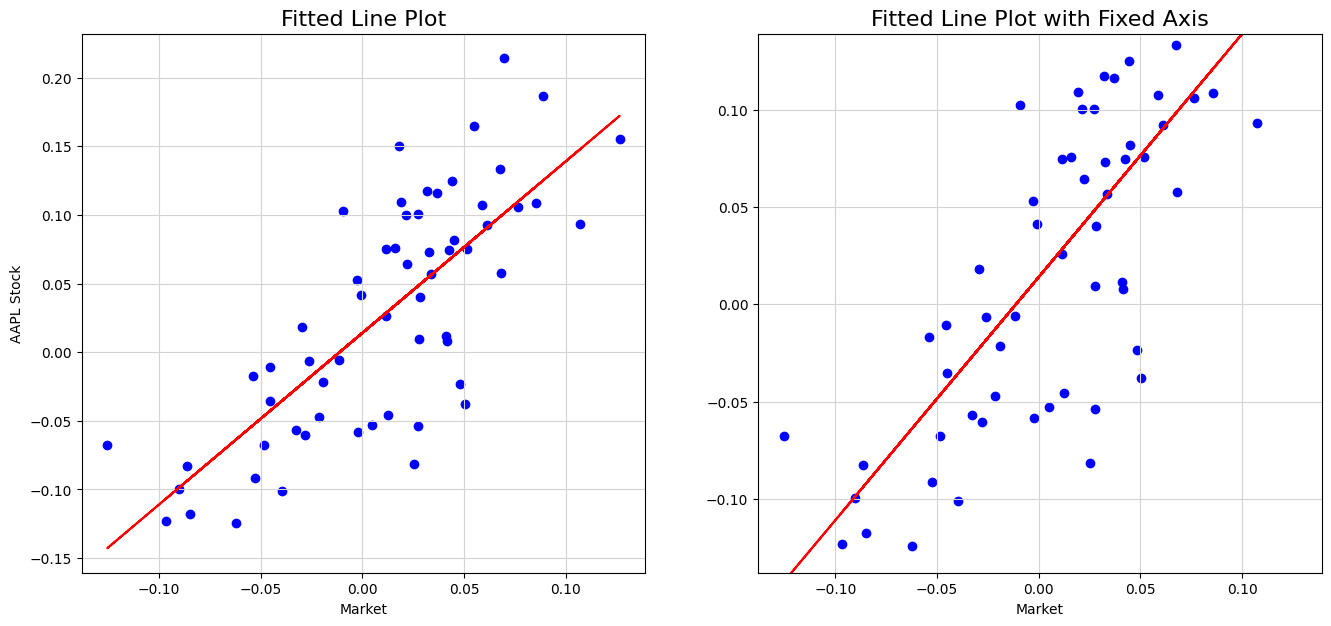

In [129]:
plt.style.use('tableau-colorblind10')

fig, axes = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(16, 7)

axes[0].scatter(Market_Premium["Market Premium"].iloc[-B:], Stock_Premium["Stock Premium"].iloc[-B:], color = 'blue')
axes[0].plot(Market_Premium["Market Premium"].iloc[-B:],Market_Premium["Market Premium"].iloc[-B:] * Beta.values + COE['Alpha'].tail(1).values, color = 'red')
axes[0].set(title = "Fitted Line Plot", xlabel =  "Market", ylabel = Trade_Name + " Stock")
axes[0].title.set_size(16)
#axes[0].grid(color = "lightgray")

axes[1].scatter(Market_Premium["Market Premium"].iloc[-B:], Stock_Premium["Stock Premium"].iloc[-B:], color = 'blue')
axes[1].plot(Market_Premium["Market Premium"].iloc[-B:],Market_Premium["Market Premium"].iloc[-B:] * Beta.values + COE['Alpha'].tail(1).values, color = 'red')
axes[1].set(title = "Fitted Line Plot with Fixed Axis", xlabel = "Market")
axes[1].title.set_size(16)
#axes[1].grid(color = "lightgray")

# Get default xlim values
default_xlim = axes[0].get_xlim()
default_ylim = axes[0].get_ylim()

# Set ylim using default xlim values and their negative counterparts
axes[1].set_ylim(default_xlim[0], default_xlim[1])
#axes.set_xlim(default_ylim[0], default_ylim[1])

for i in range(0,2):
  #axes[i].set_facecolor('white') #make background behind grid white
  axes[i].grid(color = "lightgray")

plt.show()

In [130]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Fitted Line Plot", "Fitted Line Plot with Fixed Axis"))

# Add traces for both subplots
for i in range(2):
    fig.add_trace(go.Scatter(x=Market_Premium["Market Premium"].iloc[-B:], y=Stock_Premium["Stock Premium"].iloc[-B:], mode='markers', name='Data', marker=dict(color='blue'), hoverinfo='text', text=Market_Premium["Date"].iloc[-B:].astype(str) + '<br>Market Premium: ' + Market_Premium["Market Premium"].iloc[-B:].astype(str) + '<br>Stock Premium: ' + Stock_Premium["Stock Premium"].iloc[-B:].astype(str)),
                  row=1, col=i+1)

    fig.add_trace(go.Scatter(x=Market_Premium["Market Premium"].iloc[-B:], y=Market_Premium["Market Premium"].iloc[-B:] * Beta.values + COE['Alpha'].tail(1).values, mode='lines', name='Fitted Line', line=dict(color='red')),
                  row=1, col=i+1)

# Update layout for both subplots
fig.update_xaxes(title_text='Market', row=1, col=1)
fig.update_yaxes(title_text=Trade_Name + ' Stock', row=1, col=1)
fig.update_xaxes(title_text='Market', row=1, col=2)
fig.update_yaxes(title_text=Trade_Name + ' Stock', row=1, col=2)

# Set fixed axis limits for the second subplot
fig.update_xaxes(range=[default_xlim[0], default_xlim[1]], row=1, col=2)
fig.update_yaxes(range=[default_xlim[0], default_xlim[1]], row=1, col=2)

fig.update_layout(title='Fitted Line Plot and Fitted Line Plot with Fixed Axis', width=1200, height=500)
fig.show()


# Visualization

In all sets of subplots, legends and labels are adjusted for clarity, and tight layout and subplot adjustments are applied to make the plots visually appealing.

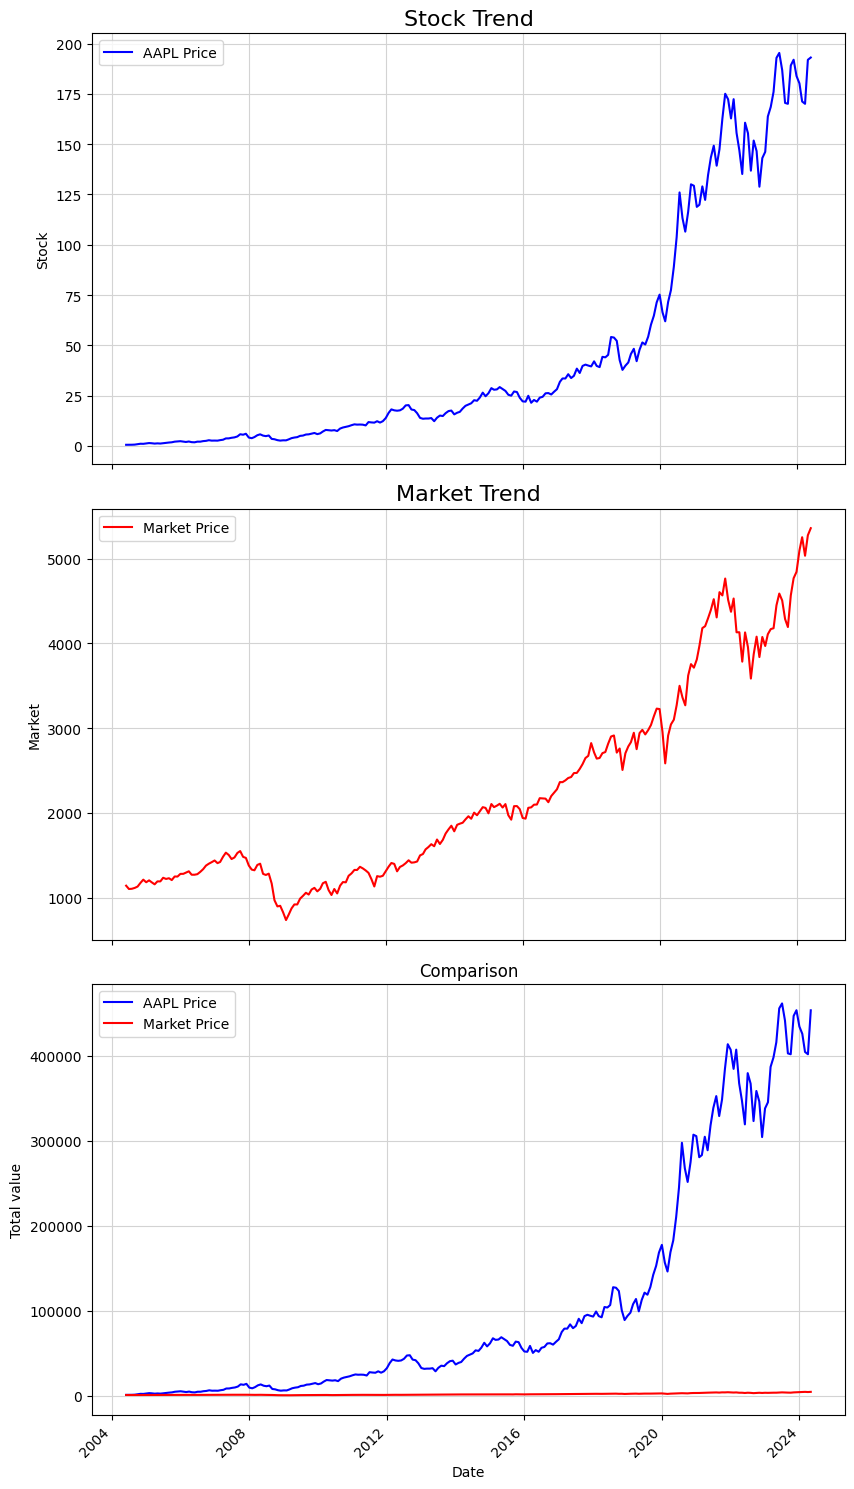

In [131]:
#This set creates three subplots vertically aligned.
#The first subplot displays the stock trend,
#The second one shows the market trend
#The third one compares the total values of the stock and market investments over time.
plt.style.use('tableau-colorblind10')

fig, axes = plt.subplots(nrows = 3, ncols = 1)
fig.set_size_inches(10, 15)
Max_Stock = Stock["Stock Value"].abs().max()*1.05
Max_Market = Market["Market Value"].abs().max()*1.05
max_abs_value = max(Max_Stock.max(), Max_Market.max()) * 1.05
max_abs_value_investment = max((COE["Market Investment"].max()), (COE["Stock Investment"].max())) * 1.05
axes[0].plot(Stock["Date"][B-1:], Stock["Stock Value"][B-1:],color="blue")
axes[0].set(title = "Stock Trend", xlabel = "Date", ylabel = "Stock")
axes[0].title.set_size(16)
plt.grid(color = "lightgray")
axes[1].plot(Market["Date"][B-1:], Market["Market Value"][B-1:],color = "red")
axes[1].set(title = "Market Trend", xlabel = "Date", ylabel = "Market")
axes[2].plot(COE["Date"], COE["Stock Investment"], color = "blue")
axes[2].plot(COE["Date"], COE["Market Investment"], color = "red")

axes[2].set(title = "Comparison", xlabel = "Date", ylabel = "Total value")

fig.autofmt_xdate(rotation=45) #format x-axis as date, rotate 45 degrees
axes[1].title.set_size(16)
"""
axes[0].set_ylim([0,Max_Stock])
axes[1].set_ylim([0,Max_Market])
axes[2].set_ylim([0,max_abs_value_investment])
"""

for i in range(0,3):
  #axes[i].set_facecolor('white') #make background behind grid white
  axes[i].grid(color = "lightgray")

axes[0].legend([Trade_Name +" Price"] ,loc = 2) #move legend to right
axes[1].legend(["Market Price"] ,loc = 2)
axes[2].legend([Trade_Name +" Price", "Market Price",] ,loc = 2)
fig.tight_layout() #use tight layout
fig.subplots_adjust(right = .85) #adjust subplots to make legend fit, adjusted this a bit from smaller figure example!

plt.show()

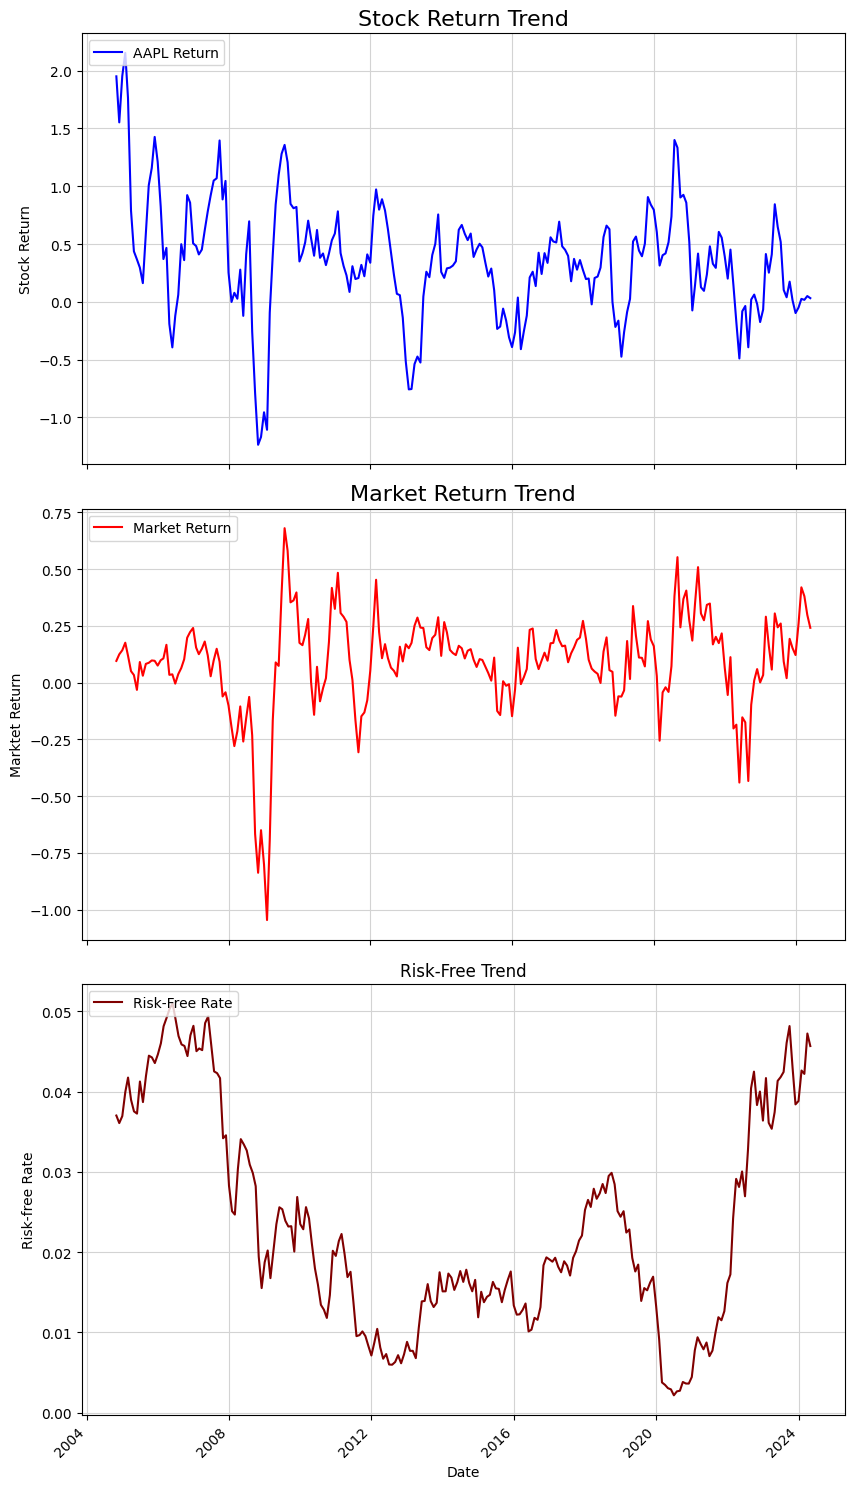

In [135]:
#This set creates another set of three subplots, vertically aligned.
#The first subplot displays the rolling mean of stock returns
#The second one shows the rolling mean of market returns
#the third one shows the rolling mean of risk-free rates over time.
plt.style.use('tableau-colorblind10')
fig, axes = plt.subplots(nrows = 3, ncols = 1)
fig.set_size_inches(10, 15)

#Moving_average_Stock = Stock["Stock Return"].rolling(12).mean()*12
#Moving_average_Market = Market["Market Return"].rolling(12).mean()*12

Moving = 6

axes[0].plot(Stock["Date"][B-1:], Stock["Stock Return"][B-1:].rolling(Moving).mean()*12, color = "blue")
axes[0].set(title = "Stock Return Trend", xlabel = "Date", ylabel = "Stock Return")
axes[0].title.set_size(16)
#plt.grid(color = "lightgray")
axes[1].plot(Market["Date"][B-1:], Market["Market Return"][B-1:].rolling(Moving).mean()*12, color = "red")
axes[1].set(title = "Market Return Trend", xlabel = "Date", ylabel = "Marktet Return")
axes[2].plot(Risk_Free["Date"][B + Moving - 1:], Risk_Free["Risk-Free Return"][B + Moving - 1:] * 12, color = "maroon")
axes[2].set(title = "Risk-Free Trend", xlabel = "Date", ylabel = "Risk-free Rate")
fig.autofmt_xdate(rotation=45) #format x-axis as date, rotate 45 degrees
axes[1].title.set_size(16)

#max_abs_value = max(Stock["Stock Return"].abs().max(), Market["Market Return"].abs().max()) * 1.05
#axes[0].set_ylim([-max_abs_value, max_abs_value])
#axes[1].set_ylim([-max_abs_value, max_abs_value])
#axes[2].set_ylim([0, Risk_Free["Risk-Free Return"].abs().max()*12*1.05])

for i in range(0,3):
  axes[i].set_facecolor('white') #make background behind grid white
  axes[i].grid(color = "lightgray")

axes[0].legend([Trade_Name +" Return"] ,loc = 2) #move legend to right
axes[1].legend(["Market Return"] ,loc = 2)
axes[2].legend(["Risk-Free Rate"] ,loc = 2)

fig.tight_layout() #use tight layout
fig.subplots_adjust(right = .85) #adjust subplots to make legend fit, adjusted this a bit from smaller figure example!

plt.show()

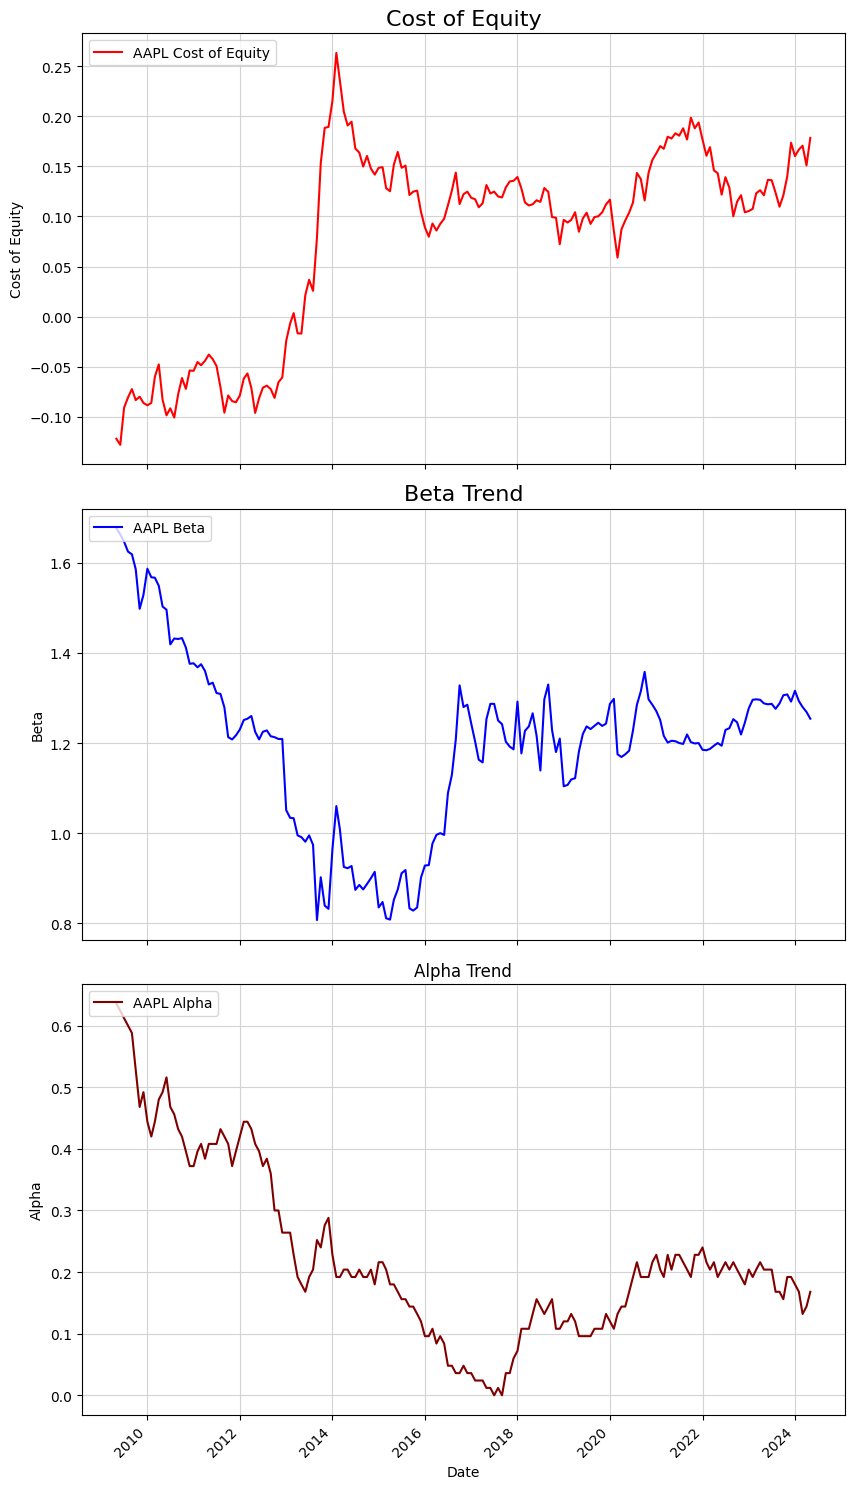

In [134]:
#This set generates a set of three subplots to visualize the trends in the cost of equity, beta, and alpha over the period of time we assign(monthly).
#The First subplot shows the rolling mean of the cost of equity over time
#The second subplot displays the trend of beta
#The third subplot shows the trend of alpha.
plt.style.use('tableau-colorblind10')
fig, axes = plt.subplots(nrows = 3, ncols = 1)
fig.set_size_inches(10, 15)

Moving = 60

axes[0].plot(COE["Date"], COE["Cost of Equity"].rolling(Moving).mean()*12, color = "red")
axes[0].set(title = "Cost of Equity", xlabel = "Date", ylabel = "Cost of Equity")
axes[0].title.set_size(16)
plt.grid(color = "lightgray")
axes[1].plot(COE["Date"][Moving-1:], COE["Beta"][Moving-1:], color = "blue")
axes[1].set(title = "Beta Trend", xlabel = "Date", ylabel = "Beta")
axes[2].plot(COE["Date"][Moving-1:], COE["Alpha"][Moving-1:]*12, color = "maroon")
axes[2].set(title = "Alpha Trend", xlabel = "Date", ylabel = "Alpha")

fig.autofmt_xdate(rotation=45) #format x-axis as date, rotate 45 degrees
axes[1].title.set_size(16)

#axes[0].set_ylim([-COE["Cost of Equity"].abs().max()*1.05*12,COE["Cost of Equity"].abs().max()*1.05*12])
#axes[1].set_ylim([COE["Beta"].min()-0.1,COE["Beta"].max()*1.05])
#axes[2].set_ylim([COE["Alpha"].min()-0.01*12,COE["Alpha"].max()*1.05*12])

for i in range(0,3):
  #axes[i].set_facecolor('white') #make background behind grid white
  axes[i].grid(color = "lightgray")

axes[0].legend([Trade_Name +" Cost of Equity"] ,loc = 2) #move legend to right
axes[1].legend([Trade_Name +" Beta"] ,loc = 2)
axes[2].legend([Trade_Name +" Alpha"] ,loc = 2)

fig.tight_layout() #use tight layout
fig.subplots_adjust(right = .85) #adjust subplots to make legend fit, adjusted this a bit from smaller figure example!

plt.show()